In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.extmath import randomized_svd

import hapod as hp


In [3]:
#specs for the snapshots matrix
n_rows = 5000
n_cols = 2000
dtype = np.float64

#simulate the maximum size of a single SVD for this machine
rank_max = 200

#fix the random generator
rng = np.random.default_rng(42)

work_dir = "/scratch/lfabris/hapod_test"

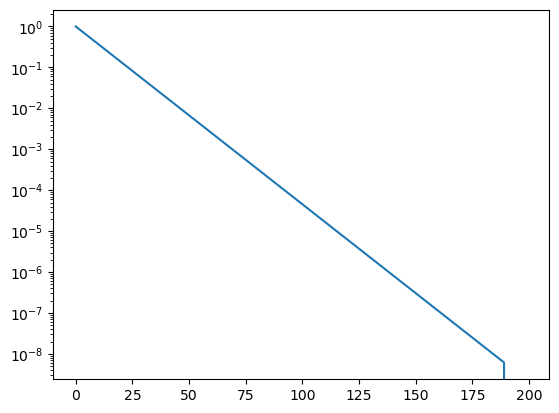

In [4]:
#prepare an array of singular values that exhibits a good decay
ranks = np.arange(0, n_cols)
# s_true = np.exp(np.exp(-ranks / 20)).astype(dtype)

s_true = np.exp(- 0.1 * ranks).astype(dtype)
s_true[rank_max - 10:] = 0

plt.semilogy(s_true[:rank_max])

plt.show()
plt.close()

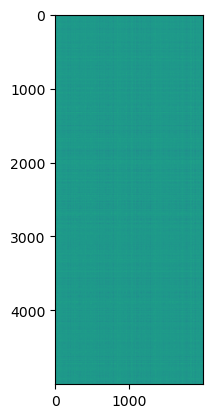

In [5]:
#build random U and V to construct the snapshots matrix
U_true, _ = np.linalg.qr(rng.random((n_rows, n_cols), dtype=dtype))
V_true, _ = np.linalg.qr(rng.random((n_cols, n_cols), dtype=dtype))
X = U_true @ np.diag(s_true) @ V_true.T

plt.imshow(X)

plt.show()
plt.close()

In [6]:
#exact POD of the snapshots, truncated to rank_max
U_np, s_np = hp.get_pod(X, rank_max=rank_max)

In [7]:
#check that the singular values are those we set during construction
assert np.allclose(s_np, s_true[:rank_max])

In [15]:
#randomized POD of the snapshots
#this simulates that rank_max columns were extracted
# random_samples = rng.choice(n_cols, rank_max, replace=False)
# U_rand, s_rand = hp.get_pod(X[:, random_samples], rank_max=rank_max)

import glob
import os

snapshots_dir = os.path.join(work_dir, "snapshots")
snapshots_fnames = list(glob.glob(os.path.join(snapshots_dir, "*.npy")))

U_rand, s_rand = hp.randomized_POD(snapshots_fnames,
                                    rank_max=100,
                                    randomizer_rng=rng)

In [16]:
U_rand.shape

(3600000, 100)

In [18]:
s_hapod = np.load(os.path.join(work_dir, "s.npy"))

In [21]:
s_rand / s_hapod[:100]

array([0.99850293, 0.99331979, 0.99332497, 0.99314281, 0.99325827,
       0.99305308, 0.99305101, 0.99307366, 0.99311063, 0.99315964,
       0.99314642, 0.99326447, 0.99318966, 0.99315708, 0.99320909,
       0.99305884, 0.99315534, 0.99315999, 0.99311097, 0.99311118,
       0.9930165 , 0.99304309, 0.99307802, 0.99302988, 0.9930247 ,
       0.99318157, 0.99299806, 0.99294922, 0.99298808, 0.99307599,
       0.99305239, 0.99290242, 0.99290321, 0.99288712, 0.99288663,
       0.99290027, 0.99288523, 0.99294149, 0.99292728, 0.99286223,
       0.99294967, 0.99292381, 0.99296958, 0.99298509, 0.9929096 ,
       0.99290158, 0.99288247, 0.99288251, 0.99288556, 0.99280201,
       0.99279069, 0.99281022, 0.9927692 , 0.99264278, 0.99260414,
       0.99269136, 0.99261826, 0.99252635, 0.99255046, 0.99241609,
       0.99254561, 0.99255268, 0.99239171, 0.99236555, 0.99234881,
       0.99223607, 0.99223087, 0.99227986, 0.99223797, 0.99228756,
       0.99219083, 0.99216559, 0.9922492 , 0.99209063, 0.99209

In [17]:
s_rand

array([29960.58830505,   550.39203248,   550.3419748 ,   550.16200179,
         550.15572735,   550.0113771 ,   549.96749067,   549.9165691 ,
         549.86045731,   549.81784686,   549.73624816,   549.69748637,
         549.6262067 ,   549.58445129,   549.54079213,   549.45449111,
         549.43261393,   549.37592384,   549.31074433,   549.29316622,
         549.23001506,   549.16676011,   549.14826558,   549.08642725,
         549.06060983,   549.04153136,   548.91199248,   548.84241561,
         548.82308262,   548.82096778,   548.74267634,   548.63189614,
         548.61195065,   548.54528533,   548.52015121,   548.49603226,
         548.4658665 ,   548.43601827,   548.39615436,   548.34279849,
         548.3083928 ,   548.27115505,   548.22670079,   548.18600708,
         548.13395103,   548.09540391,   548.05592076,   548.01316818,
         547.99565338,   547.9207776 ,   547.87423023,   547.84635293,
         547.77739553,   547.69934678,   547.64878325,   547.64752977,
      

In [9]:
#prepare the chunks for hapod
#each chunk must be at most half the size of rank_max
chunk_rank_max = rank_max // 2

#tune the number of chunks so that the tree of merges will be full
n_chunks = hp.get_n_chunks_fulltree(n_cols, 
                                    n_chunk_max_cols=chunk_rank_max)

#build a list of chunks; starting from the single snapshots
#here, the chunks will be kept in memory, while the default behavior is to store them on disk
Xs = hp.make_chunks(np.array_split(X, n_cols, axis=1),
                    ".",
                    n_chunks=n_chunks,
                    serializer=hp.InMemorySerializer(),
                    # randomizer_rng=rng,
                    )

verbose = True

In [10]:
#perform hapod keeping the intermediate results in memory
U_hp, s_hp = hp.hapod(Xs,
                      chunk_rank_max=chunk_rank_max,
                      serializer=hp.InMemorySerializer(),
                      verbose=verbose,
                      )

Xs
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), 

In [11]:
#randomized HAPOD
random_samples = rng.choice(n_cols, rank_max, replace=False)
U_hp_rand, s_hp_rand = hp.hapod([X[:, random_samples]],
                      chunk_rank_max=chunk_rank_max,
                      serializer=hp.InMemorySerializer(),
                      verbose=verbose,
                      )

Xs
    ((5000, 200), dtype('float64'))
last chunk
    ((5000, 200), dtype('float64'))
    U.shape (5000, 200)
    took 0.098


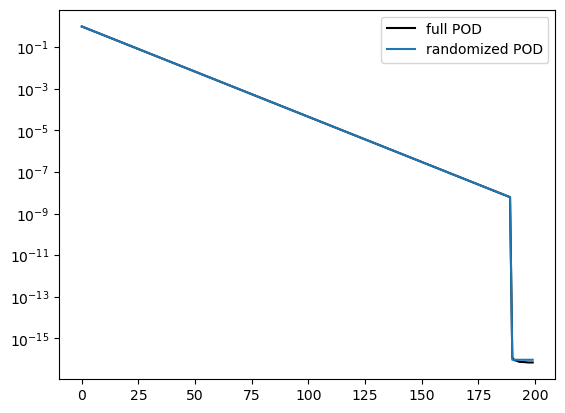

In [15]:
#compare the singular values
plt.semilogy(s_np, label="full POD", c="black")
plt.semilogy(s_rand, label="randomized POD")
# plt.semilogy(s_hp, label="HAPOD")
# plt.semilogy(s_hp_rand, label="randomized HAPOD")
# plt.semilogy(s_hp_file, label="hapod file")

plt.legend()

plt.show()
plt.close()

In [22]:
U_hapod = np.load(os.path.join(work_dir, "U.npy"))

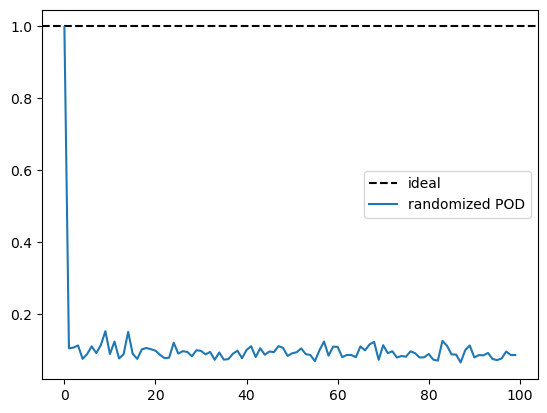

In [24]:
ortho_rand = np.max(np.abs(U_rand.T @ U_hapod[:, :100]), axis=0)

plt.axhline(1, linestyle="--", c="black", label="ideal")

plt.plot(ortho_rand, label="randomized POD")

plt.legend()

plt.show()
plt.close()

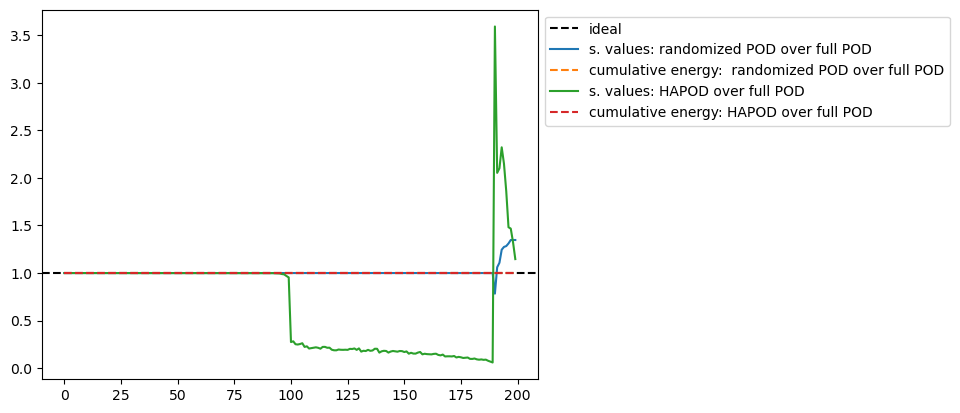

In [14]:

plt.axhline(1, linestyle="--", c="black", label="ideal")

plt.plot(s_rand / s_np, 
         label="s. values: randomized POD over full POD")
plt.plot(hp.get_cumulative_energy_ratios(s_rand)
            / hp.get_cumulative_energy_ratios(s_np),
         linestyle="--",
         label="cumulative energy:  randomized POD over full POD")

plt.plot(s_hp / s_np, 
         label="s. values: HAPOD over full POD")
plt.plot(hp.get_cumulative_energy_ratios(s_hp)
            / hp.get_cumulative_energy_ratios(s_np),
         linestyle="--",
         label="cumulative energy: HAPOD over full POD")


plt.legend(loc="upper left", 
           bbox_to_anchor=(1, 1))

plt.show()
plt.close()